# Iris Classification

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings("ignore")


# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="species")

In [3]:
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (150, 4)
Target shape: (150,)


In [4]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
target_names = dict(enumerate(iris.target_names))
y_named = y.map(target_names)
y_named.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object

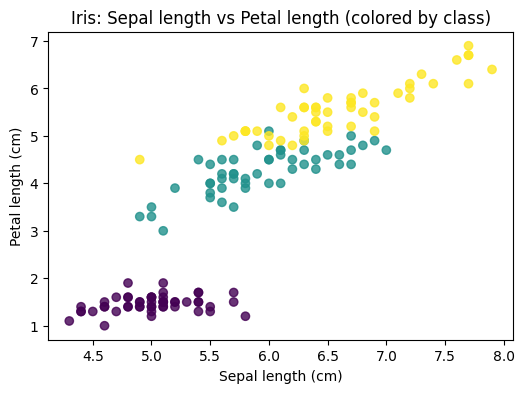

In [6]:
# Graph of dataset, color set by label. 
plt.figure(figsize=(6,4))
plt.scatter(X['sepal length (cm)'], X['petal length (cm)'], c=y, alpha=0.8)
plt.xlabel('Sepal length (cm)')
plt.ylabel('Petal length (cm)')
plt.title('Iris: Sepal length vs Petal length (colored by class)')
plt.show()

## Frame the ML problem
- Type: Multi-class classification
- Features (X): 4 numeric measurements
- Target (y): species (3 classes)
- Primary metric: Accuracy (simple starting point)
- Baselines: “Most frequent class” accuracy to beat

### Train Test Split    

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [8]:
print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])

Train size: 120  Test size: 30


## Establish a baseline

In [9]:
baseline = DummyClassifier(strategy="most_frequent", random_state=SEED)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
base_acc = accuracy_score(y_test, y_pred_base)
print(f"Baseline accuracy (most frequent class): {base_acc:.3f}")

Baseline accuracy (most frequent class): 0.333


## Build a pipeline and train a KNN model

In [10]:
knn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
])

In [11]:
knn_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [12]:
y_pred = knn_pipeline.predict(X_test)

In [13]:
acc = accuracy_score(y_test, y_pred)
print(f"KNN (k=5) accuracy: {acc:.3f}")

KNN (k=5) accuracy: 0.933


In [14]:
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [15]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


#### Base classification metrics
- Precision: Of predicted class A, how many were actually A?
- Recall: Of actual class A, how many did we find?
- F1: Balance between precision & recall (per class).

### Hyperparameter search (GridSearchCV)

In [16]:
param_grid = {"knn__n_neighbors": list(range(1, 16))}

In [17]:
grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

In [18]:
grid.fit(X_train, y_train)
print("Best CV params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best CV params: {'knn__n_neighbors': 5}
Best CV score: 0.9666666666666668


In [19]:
# Evaluate best model on the test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy with best k: {acc_best:.3f}")
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_best))

Test accuracy with best k: 0.933

Confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


###  Minimal error analysis

In [20]:
mis_idx = np.where(y_test != y_pred_best)[0]
print("Misclassified indices (in test set order):", mis_idx)
if len(mis_idx) > 0:
    # Show their feature rows and true/pred labels
    err_rows = X_test.iloc[mis_idx].copy()
    err_rows['true'] = y_test.iloc[mis_idx].values
    err_rows['pred'] = y_pred_best[mis_idx]
    err_rows['true_name'] = err_rows['true'].map(target_names)
    err_rows['pred_name'] = err_rows['pred'].map(target_names)
    display(err_rows)
else:
    print("No misclassifications this run.")

Misclassified indices (in test set order): [19 23]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),true,pred,true_name,pred_name
138,6.0,3.0,4.8,1.8,2,1,virginica,versicolor
134,6.1,2.6,5.6,1.4,2,1,virginica,versicolor


## Compare with Logistic Regression

In [21]:
logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=500, multi_class="auto"))
])

In [22]:
logreg_pipeline.fit(X_train, y_train)
y_pred_lr = logreg_pipeline.predict(X_test)
print("LogReg test accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

LogReg test accuracy: 0.9333333333333333
Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [23]:
print("\nClassification report Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=iris.target_names))


Classification report Logistic Regression:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

